In [6]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import sys
sys.path.append('../lib')
from collections import Counter
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.ndimage import shift
from scipy.signal import fftconvolve
from numpy.linalg import norm
from scipy.optimize import curve_fit
import pickle
from detection_methods import compare_trajectory_method, trajectory_mean, trajectory_corr, trajectory_till, trajectory_till_stepwise, trajectory_gauss, plt_accuracy_results,reload_results make_test_trajectory, trajectory_polar_comparison,save_result, compare_trajectories
import os
    

ImportError: cannot import name 'reload_results' from 'detection_methods' (c:\Users\jschulz\Desktop\Git_file\mbr_relevant_code\simulations\../lib\detection_methods.py)

In [2]:
filename=r'\\134.76.13.158\betzlab\Julian\microcope_scripts\detection\data\Hz10_oscillation\_100nm.npy'
movie = np.load(filename)
movie=movie.astype(np.int32)

In [3]:
experiment_name='comparison_of_location_frankenstein'
filelocation=r'\\134.76.13.158\betzlab\Julian\microcope_scripts\detection\data\comparison_of_location_frankenstein'
location=filelocation
print(location)
#os.mkdir(location)

\\134.76.13.158\betzlab\Julian\microcope_scripts\detection\data\comparison_of_location_frankenstein


In [4]:
os.listdir(filelocation)

[]

In [5]:
results_list=reload_results(filelocation)

NameError: name 'reload_results' is not defined

In [23]:
results_list

[]

In [21]:



def reload_results(location):
    # Get list of all pickle files in the directory
    files = [f for f in os.listdir(location) if f.endswith('.pkl')]
    
    results_list = []
    for file in files:
        file_path = os.path.join(location, file)
        with open(file_path, 'rb') as f:
            result = pickle.load(f)
            results_list.append(result)
    
    return results_list

results_list=reload_results(filelocation)

results_corr, results_rotgauss, results_mean, results_till, results_till_stepwise = results_list

ValueError: not enough values to unpack (expected 5, got 0)

In [10]:
timesteps=1000
min_step=0.01
max_step=5
picture_noise=8
result_frank=compare_trajectory_method(trajectory_frankenstein,movie[0],min_step=min_step, max_step=max_step,timesteps=timesteps, picture_noise=picture_noise )

results_rotgauss=compare_trajectory_method(trajectory_gauss,movie[0],min_step=min_step, max_step=max_step,timesteps=timesteps, picture_noise=picture_noise )
results_till=compare_trajectory_method(trajectory_till,movie[0],min_step=min_step, max_step=max_step,timesteps=timesteps, picture_noise=picture_noise )
results_till_stepwise=compare_trajectory_method(trajectory_till_stepwise,movie[0],min_step=min_step, max_step=max_step,timesteps=timesteps, picture_noise=picture_noise )
results_mean=compare_trajectory_method(trajectory_mean,movie[0],min_step=min_step, max_step=max_step,timesteps=timesteps, picture_noise=picture_noise)
results_corr=compare_trajectory_method(trajectory_corr,movie[0],min_step=min_step, max_step=max_step,timesteps=timesteps, picture_noise=picture_noise )
results_list=[results_till,results_till_stepwise,results_mean,results_corr,results_rotgauss,trajectory_frankenstein]


NameError: name 'trajectory_frankenstein' is not defined

In [45]:

for result in results_list:
    save_result(result['name'], location, result)

In [46]:

def save_current_plot(name, location):
    os.makedirs(location, exist_ok=True)  # Make sure the directory exists

    png_path = os.path.join(location, f"{name}.png")
    plt.savefig(png_path)

    svg_path = os.path.join(location, f"{name}.svg")
    plt.savefig(svg_path)

In [106]:
result_frank=compare_trajectory_method(trajectory_frankenstein,movie[0],min_step=min_step, max_step=max_step,timesteps=timesteps, picture_noise=picture_noise )


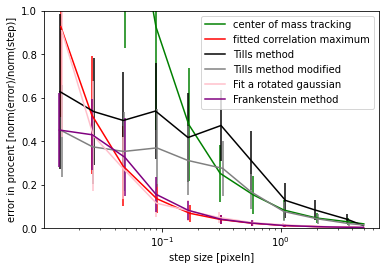

In [110]:
plt_accuracy_results(results_mean, 'center of mass tracking', 'green')
plt_accuracy_results(results_corr, 'fitted correlation maximum', 'red')
plt_accuracy_results(results_till, 'Tills method', 'black')
plt_accuracy_results(results_till_stepwise, 'Tills method modified', 'grey')
plt_accuracy_results(results_rotgauss, 'Fit a rotated gaussian', 'pink')
plt_accuracy_results(result_frank, 'Frankenstein method', 'purple')
r_parity=0.05
#plt.plot([r_parity,r_parity],[0,1])
plt.ylim(0,1)
plt.xlabel("step size [pixeln]")
plt.ylabel("error in procent [norm(error)/norm(step)]")
plt.xscale('log')
plt.legend()
#save_current_plot('performance_plot',location)

In [105]:
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta
def polar_to_cartesian(r, theta):
    x=r*np.cos(theta)
    y=r*np.sin(theta)
    return x,y
def disassemble_trajectory(trajectory):
    steps = np.diff(trajectory, axis=0)
    polar_steps = cartesian_to_polar(steps[:, 0], steps[:, 1])
    return np.array(polar_steps).T
def assemble_trajectory(polar_steps):
    tra=[[0,0]]
    for step in polar_steps:
        dx,dy =polar_to_cartesian(step[0],step[1])
        tra.append([tra[-1][0]+dx,tra[-1][1]+dy])
    return np.array(tra)

def trajectory_frankenstein(movie):
    tra_corr=trajectory_corr(movie)
    tra_till_stepwise=trajectory_till_stepwise(movie)
    steps_corr = disassemble_trajectory(tra_corr)
    steps_till_stepwise = disassemble_trajectory(tra_till_stepwise)

    #r_parity=0.03
    r_parity=0.05
    bigger_then_parity=steps_corr[:,0]>r_parity
    r_frank=bigger_then_parity*steps_corr[:,0]+(bigger_then_parity==False)*steps_till_stepwise[:,0]
    theta_frank=bigger_then_parity*steps_corr[:,1]+(bigger_then_parity==False)*steps_till_stepwise[:,1]
    #theta_frank=steps_till_stepwise[:,1]
    #theta_frank=steps_corr[:,1]
    frank_polar_steps=np.stack([r_frank,theta_frank],1)

    return assemble_trajectory(frank_polar_steps)


In [91]:
test_traj, test_movie = make_test_trajectory(movie[0], 0.01, 1, 8, 100)


In [92]:
tra_frank=trajectory_frankenstein(test_movie)
tra_corr=trajectory_corr(test_movie)

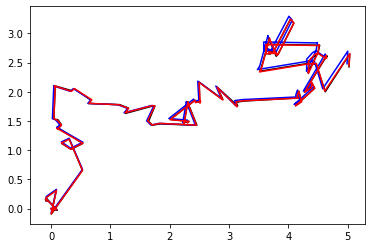

In [93]:
plt.plot(test_traj[:,0],test_traj[:,1],"black")
plt.plot(tra_frank[:,0],tra_frank[:,1],"blue")
plt.plot(tra_corr[:,0],tra_corr[:,1],"red")

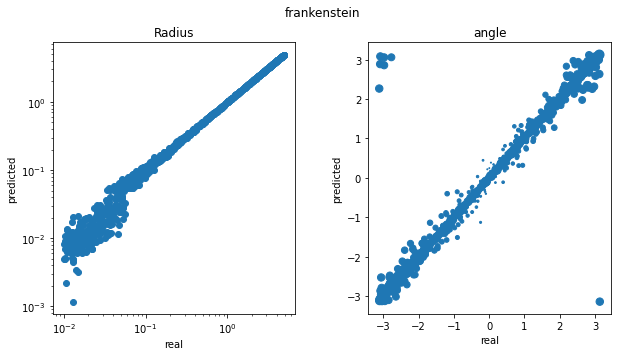

In [111]:
steps_polar, calc_steps_polar= trajectory_polar_comparison(result_frank,"frankenstein")

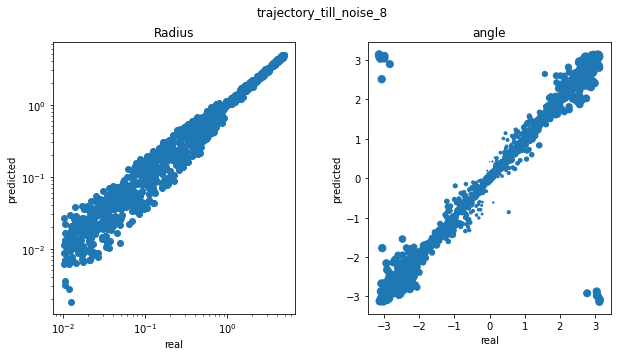

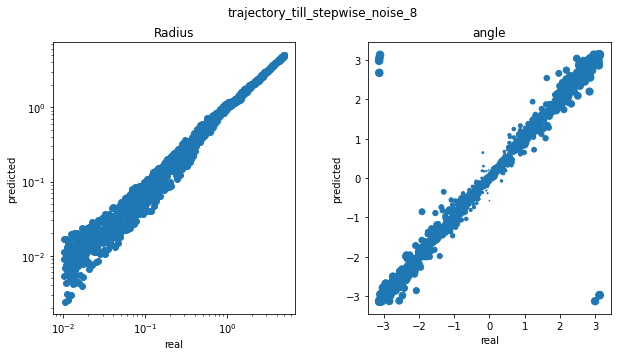

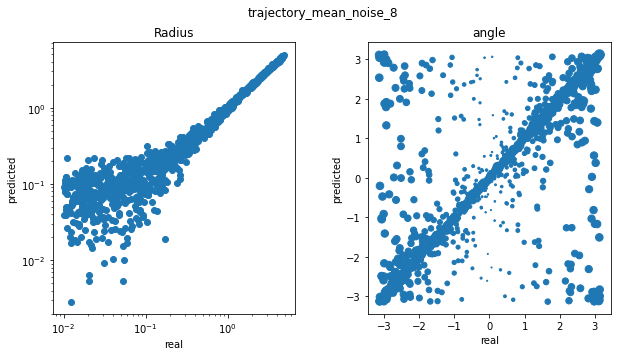

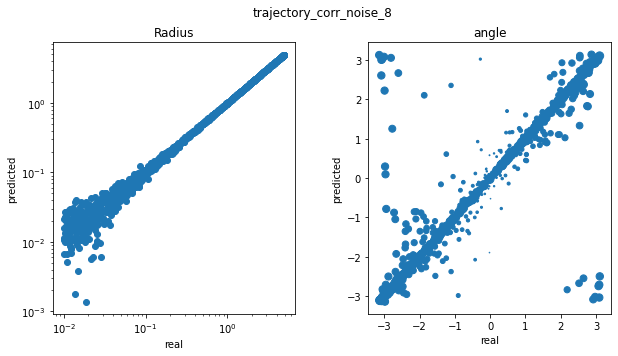

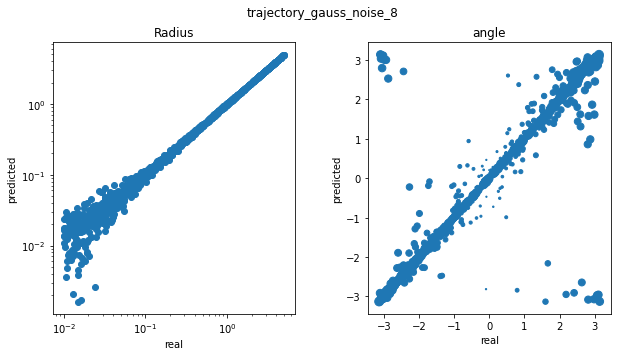

In [13]:
for result in results_list:
    steps_polar, calc_steps_polar= trajectory_polar_comparison(result,result['name'])
    #save_current_plot('polar_comarison'+result['name'],location)

In [25]:
def phantom_step_size(method, image, noise_level):
    timesteps=100
    test_traj, test_movie=make_test_trajectory(image,0,0,noise_level,timesteps)
    calc_teay=method(test_movie)
    step_sizes=[]
    for i in range(len(calc_teay)-1):
        step_sizes.append(norm(calc_teay[i+1]-calc_teay[i]))
    return np.mean(step_sizes)
def phantom_step_noise_dependence(method, image, min_noise=1,max_noise=100):
    noise_arr = np.logspace(np.log10(min_noise),np.log10(max_noise), 10)
    phantom_step_arr=[phantom_step_size(method, image, noise_level) for noise_level in noise_arr]
    return noise_arr, phantom_step_arr
    

In [26]:
noise_arr, phantom_steps_mean=phantom_step_noise_dependence(trajectory_mean,movie[0])
noise_arr, phantom_steps_corr=phantom_step_noise_dependence(trajectory_corr,movie[0])
noise_arr, phantom_steps_gauss=phantom_step_noise_dependence(trajectory_gauss,movie[0])
noise_arr, phantom_steps_till=phantom_step_noise_dependence(trajectory_till,movie[0])
noise_arr, phantom_steps_till_stepwise=phantom_step_noise_dependence(trajectory_till_stepwise,movie[0])


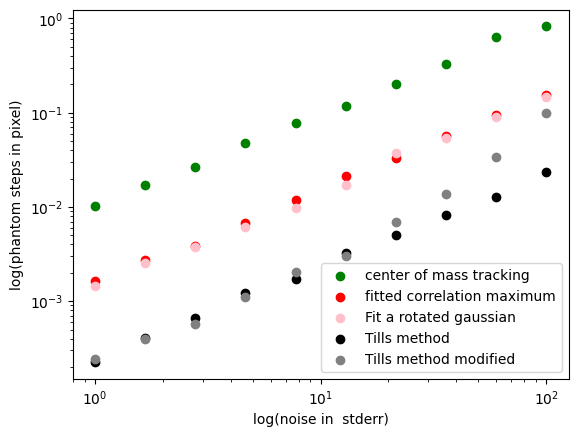

In [27]:
plt.scatter(noise_arr,phantom_steps_mean, label='center of mass tracking', color='green')
plt.scatter(noise_arr,phantom_steps_corr,label='fitted correlation maximum', color='red')
plt.scatter(noise_arr,phantom_steps_gauss, label= 'Fit a rotated gaussian', color='pink')
plt.scatter(noise_arr,phantom_steps_till, label='Tills method', color='black')
plt.scatter(noise_arr,phantom_steps_till_stepwise, label=  'Tills method modified', color='grey')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("log(noise in  stderr)")
plt.ylabel("log(phantom steps in pixel)")
plt.show()